# Probabilistic-Matrix-Factorization

- [Repositorio](https://github.com/fuhailin/Probabilistic-Matrix-Factorization/tree/master)

- [Paper](https://proceedings.neurips.cc/paper_files/paper/2007/hash/d7322ed717dedf1eb4e6e52a37ea7bcd-Abstract.html)

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
import random
from sklearn.model_selection import train_test_split
import nbformat as nbf
import pathlib, os
from pathlib import Path
import pandas as pd

## 1. Cargar BD 

    Unicamente devuelve las columnas user_id, item_id, rating

In [32]:
# ---------- utilidades ----------
def _to_base0_user_item(arr):
    """arr: ndarray (N, >=3) con user,item,... convertidos a base-0 (si vienen 1..N)."""
    arr = arr.copy()
    arr[:,0] -= 1
    arr[:,1] -= 1
    return arr

def _reindex_consecutive(arr):
    """
    Reindexa user/item a índices consecutivos 0..U-1 y 0..I-1.
    Útil para datasets donde los IDs no son 1..N (p.ej. ml-latest-small, ml-1m).
    Devuelve:
      arr_reindexed (N,3), user_map (dict orig->new), item_map (dict orig->new)
    """
    users_orig = arr[:,0].astype(np.int64)
    items_orig = arr[:,1].astype(np.int64)
    uniq_u, u_new = np.unique(users_orig, return_inverse=True)
    uniq_i, i_new = np.unique(items_orig, return_inverse=True)
    arr_new = np.c_[u_new, i_new, arr[:,2].astype(np.float64)]
    u_map = {int(u): int(i) for i, u in enumerate(uniq_u)}
    i_map = {int(m): int(i) for i, m in enumerate(uniq_i)}
    return arr_new, u_map, i_map

# ---------- loaders ----------
def load_ml100k_u_data(path="data/u.data"):
    """user\titem\trating\ttimestamp (IDs 1-based)"""
    arr = np.loadtxt(path, dtype=np.int64)
    arr = _to_base0_user_item(arr)[:, :3].astype(np.float64)
    return arr

def load_ml100k_fold(k=1, root="data"):
    """u{k}.base / u{k}.test (IDs 1-based)"""
    root = Path(root)
    train = np.loadtxt(root / f"u{k}.base", dtype=np.int64)
    test  = np.loadtxt(root / f"u{k}.test",  dtype=np.int64)
    train = _to_base0_user_item(train)[:, :3].astype(np.float64)
    test  = _to_base0_user_item(test)[:,  :3].astype(np.float64)
    return train, test

def load_ml100k_uab(which="ua", root="data"):
    """ua.base/ua.test o ub.base/ub.test (IDs 1-based)"""
    assert which in {"ua","ub"}
    root = Path(root)
    train = np.loadtxt(root / f"{which}.base", dtype=np.int64)
    test  = np.loadtxt(root / f"{which}.test", dtype=np.int64)
    train = _to_base0_user_item(train)[:, :3].astype(np.float64)
    test  = _to_base0_user_item(test)[:,  :3].astype(np.float64)
    return train, test

def load_ml_latest_small_csv(path="data/ml-latest-small/ratings.csv", reindex=True):
    """CSV con cabecera: userId,movieId,rating,timestamp (IDs no consecutivos)."""
    df = pd.read_csv(path)
    arr = np.c_[df["userId"].to_numpy(), df["movieId"].to_numpy(), df["rating"].to_numpy()].astype(np.float64)
    if reindex:
        arr, u_map, i_map = _reindex_consecutive(arr)
        return arr, u_map, i_map
    # si no reindexas, al menos pasa a base-0 (puede que queden huecos)
    arr[:,0] -= 1; arr[:,1] -= 1
    return arr, None, None

def load_ml1m_dat(path="data/ml-1m/ratings.dat", reindex=True):
    """ratings.dat: userId::movieId::rating::timestamp (IDs no consecutivos)."""
    df = pd.read_csv(path, sep="::", engine="python",
                     names=["userId","movieId","rating","timestamp"])
    arr = np.c_[df["userId"].to_numpy(), df["movieId"].to_numpy(), df["rating"].to_numpy()].astype(np.float64)
    if reindex:
        arr, u_map, i_map = _reindex_consecutive(arr)
        return arr, u_map, i_map
    arr[:,0] -= 1; arr[:,1] -= 1
    return arr, None, None

# ---------- selector cómodo ----------
def get_dataset(kind="u.data", root="data", fold=1, which="ua"):
    """
    kind: "u.data" | "u.fold" | "u.ab" | "latest-small" | "ml-1m"
    Devuelve (train, test) o (ratings, None) si no hay split predefinido.
    """
    if kind == "u.data":
        ratings = load_ml100k_u_data(Path(root)/"u.data")
        return ratings, None
    elif kind == "u.fold":
        return load_ml100k_fold(fold, root=root)
    elif kind == "u.ab":
        return load_ml100k_uab(which, root=root)
    elif kind == "latest-small":
        ratings, *_ = load_ml_latest_small_csv(Path(root)/"ratings.csv", reindex=True)
        return ratings, None
    elif kind == "ml-1m":
        ratings, *_ = load_ml1m_dat(Path(root)/"ratings.dat", reindex=True)
        return ratings, None
    else:
        raise ValueError("kind desconocido")



In [54]:
def _to_base0_user_item(arr):
    arr = arr.copy()
    arr[:,0] -= 1; arr[:,1] -= 1
    return arr

def _reindex_consecutive(arr):
    """IDs -> consecutivos (0..U-1, 0..I-1). Devuelve (arr3, user_map, item_map)."""
    uo = arr[:,0].astype(np.int64); io = arr[:,1].astype(np.int64)
    uuniq, u_new = np.unique(uo, return_inverse=True)
    iuniq, i_new = np.unique(io, return_inverse=True)
    arr3 = np.c_[u_new, i_new, arr[:,2].astype(np.float64)]
    return arr3, {int(u):int(j) for j,u in enumerate(uuniq)}, {int(m):int(j) for j,m in enumerate(iuniq)}

# ---------- loaders ----------
def load_ml100k_u_data(path):
    arr = np.loadtxt(path, dtype=np.int64)
    return _to_base0_user_item(arr)[:, :3].astype(np.float64)

def load_ml100k_fold(root, k):
    tr = np.loadtxt(Path(root)/f"u{k}.base", dtype=np.int64)
    te = np.loadtxt(Path(root)/f"u{k}.test", dtype=np.int64)
    return _to_base0_user_item(tr)[:, :3].astype(np.float64), _to_base0_user_item(te)[:, :3].astype(np.float64)

def load_ml100k_uab(root, which):
    tr = np.loadtxt(Path(root)/f"{which}.base", dtype=np.int64)
    te = np.loadtxt(Path(root)/f"{which}.test", dtype=np.int64)
    return _to_base0_user_item(tr)[:, :3].astype(np.float64), _to_base0_user_item(te)[:, :3].astype(np.float64)

def load_ml_latest_small_csv(path, reindex=True):
    df = pd.read_csv(path)
    arr = np.c_[df.userId.values, df.movieId.values, df.rating.values].astype(np.float64)
    return _reindex_consecutive(arr)[0] if reindex else _to_base0_user_item(arr)[:, :3].astype(np.float64)

def load_ml1m_dat(path, reindex=True):
    df = pd.read_csv(path, sep="::", engine="python",
                     names=["userId","movieId","rating","timestamp"])
    arr = np.c_[df.userId.values, df.movieId.values, df.rating.values].astype(np.float64)
    return _reindex_consecutive(arr)[0] if reindex else _to_base0_user_item(arr)[:, :3].astype(np.float64)

# ---------- dispatcher ----------
def prepare_data(DATASET, test_size=0.2, random_state=42):
    """
    DATASET examples:
      {"kind":"u.data", "root":"data"}
      {"kind":"u.fold", "root":"data", "fold":1}
      {"kind":"u.ab",   "root":"data", "which":"ua"}  # o "ub"
      {"kind":"latest-small", "path":"data/ml-latest-small/ratings.csv"}
      {"kind":"ml-1m",        "path":"data/ml-1m/ratings.dat"}
      {"kind":"auto", "root":"data"}   # intenta detectar
    Devuelve (train, test, meta_dict)
    """
    kind = DATASET.get("kind", "u.data")
    meta = {"kind": kind}

    # detección sencilla
    if kind == "auto":
        root = Path(DATASET.get("root", "data"))
        if (root/"u1.base").exists() and (root/"u1.test").exists():
            kind = "u.fold"; DATASET = {"kind":"u.fold","root":str(root), "fold":1}
        elif (root/"ua.base").exists() and (root/"ua.test").exists():
            kind = "u.ab"; DATASET = {"kind":"u.ab","root":str(root), "which":"ua"}
        elif (root/"u.data").exists():
            kind = "u.data"; DATASET = {"kind":"u.data","root":str(root)}
        meta["kind"] = kind

    if kind == "u.data":
        root = DATASET.get("root","data")
        ratings = load_ml100k_u_data(Path(root)/"u.data")
        train, test = train_test_split(ratings, test_size=test_size, random_state=random_state)
        meta.update({"users": int(ratings[:,0].max())+1, "items": int(ratings[:,1].max())+1})
        return train, test, meta

    if kind == "u.fold":
        root = DATASET.get("root","data"); fold = int(DATASET.get("fold",1))
        train, test = load_ml100k_fold(root, fold)
        meta.update({"fold": fold, "users": int(max(train[:,0].max(), test[:,0].max()))+1,
                     "items": int(max(train[:,1].max(), test[:,1].max()))+1})
        return train, test, meta

    if kind == "u.ab":
        root = DATASET.get("root","data"); which = DATASET.get("which","ua")
        train, test = load_ml100k_uab(root, which)
        meta.update({"which": which, "users": int(max(train[:,0].max(), test[:,0].max()))+1,
                     "items": int(max(train[:,1].max(), test[:,1].max()))+1})
        return train, test, meta

    if kind == "latest-small":
        path = DATASET.get("path", "data/ml-latest-small/ratings.csv")
        ratings = load_ml_latest_small_csv(path, reindex=True)
        train, test = train_test_split(ratings, test_size=test_size, random_state=random_state)
        meta.update({"users": int(ratings[:,0].max())+1, "items": int(ratings[:,1].max())+1})
        return train, test, meta

    if kind == "ml-1m":
        path = DATASET.get("path", "data/ml-1m/ratings.dat")
        ratings = load_ml1m_dat(path, reindex=True)
        train, test = train_test_split(ratings, test_size=test_size, random_state=random_state)
        meta.update({"users": int(ratings[:,0].max())+1, "items": int(ratings[:,1].max())+1})
        return train, test, meta

    raise ValueError(f"kind desconocido: {kind}")

In [59]:
# Elegir 1:
# DATASET = {"kind":"u.data", "root":"data"}                  # u.data (split aleatorio)
# DATASET = {"kind":"u.fold", "root":"data", "fold":1}      # u1.base/u1.test
# DATASET = {"kind":"u.ab", "root":"data", "which":"ua"}    # ua.base/ua.test  (o "ub")
# DATASET = {"kind":"latest-small", "path":"data/ml-latest-small/ratings.csv"}
# DATASET = {"kind":"ml-1m", "path":"data/ml-1m/ratings.dat"}
DATASET = {"kind":"auto", "root":"data"}                  # autodetecta

## 2. Train /test

    Dividir el dataset en train (80%) y test(20%)

In [60]:
train, test, meta = prepare_data(DATASET, test_size=0.2, random_state=42)
print(meta)

{'kind': 'u.fold', 'fold': 1, 'users': 943, 'items': 1682}


## 3. Definir PMF

    (La Clase PMF es igual que la del repositorio)

In [36]:
# -*- coding: utf-8 -*-
import numpy as np


class PMF(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)

        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors

        self.rmse_train = []
        self.rmse_test = []

    # ***Fit the model with train_tuple and evaluate RMSE on both train and test data.  ***********#
    # ***************** train_vec=TrainData, test_vec=TestData*************#
    def fit(self, train_vec, test_vec):
        # mean subtraction
        self.mean_inv = np.mean(train_vec[:, 2])  # 评分平均值

        pairs_train = train_vec.shape[0]  # traindata 中条目数
        pairs_test = test_vec.shape[0]  # testdata中条目数

        # 1-p-i, 2-m-c
        num_user = int(max(np.amax(train_vec[:, 0]), np.amax(test_vec[:, 0]))) + 1  # 第0列，user总数
        num_item = int(max(np.amax(train_vec[:, 1]), np.amax(test_vec[:, 1]))) + 1  # 第1列，movie总数

        incremental = False  # 增量
        if ((not incremental) or (self.w_Item is None)):
            # initialize
            self.epoch = 0
            self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat)  # numpy.random.randn 电影 M x D 正态分布矩阵
            self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)  # numpy.random.randn 用户 N x D 正态分布矩阵

            self.w_Item_inc = np.zeros((num_item, self.num_feat))  # 创建电影 M x D 0矩阵
            self.w_User_inc = np.zeros((num_user, self.num_feat))  # 创建用户 N x D 0矩阵

        while self.epoch < self.maxepoch:  # 检查迭代次数
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  # 根据记录数创建等差array
            np.random.shuffle(shuffled_order)  # 用于将一个列表中的元素打乱

            # Batch update
            for batch in range(self.num_batches):  # 每次迭代要使用的数据量
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # 本次迭代要使用的索引下标

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Objective Function
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],
                                              self.w_Item[batch_ItemID, :]),
                                  axis=1)  # mean_inv subtracted # np.multiply对应位置元素相乘

                rawErr = pred_out - train_vec[shuffled_order[batch_idx], 2] + self.mean_inv

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Objective Function after
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(train_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(train_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - train_vec[:, 2] + self.mean_inv
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(test_vec[:, 0], dtype='int32'), :],
                                                  self.w_Item[np.array(test_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  # mean_inv subtracted
                    rawErr = pred_out - test_vec[:, 2] + self.mean_inv
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_test))

                    # Print info
                    if batch == self.num_batches - 1:
                        print('Training RMSE: %f, Test RMSE %f' % (self.rmse_train[-1], self.rmse_test[-1]))

    def predict(self, invID):
        return np.dot(self.w_Item, self.w_User[int(invID), :]) + self.mean_inv  # numpy.dot 点乘

    # ****************Set parameters by providing a parameter dictionary.  ***********#
    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)

    def topK(self, test_vec, k=10):
        inv_lst = np.unique(test_vec[:, 0])
        pred = {}
        for inv in inv_lst:
            if pred.get(inv, None) is None:
                pred[inv] = np.argsort(self.predict(inv))[-k:]  # numpy.argsort索引排序

        intersection_cnt = {}
        for i in range(test_vec.shape[0]):
            if test_vec[i, 1] in pred[test_vec[i, 0]]:
                intersection_cnt[test_vec[i, 0]] = intersection_cnt.get(test_vec[i, 0], 0) + 1
        invPairs_cnt = np.bincount(np.array(test_vec[:, 0], dtype='int32'))

        precision_acc = 0.0
        recall_acc = 0.0
        for inv in inv_lst:
            precision_acc += intersection_cnt.get(inv, 0) / float(k)
            recall_acc += intersection_cnt.get(inv, 0) / float(invPairs_cnt[int(inv)])

        return precision_acc / len(inv_lst), recall_acc / len(inv_lst)

## 4. Definir modelo PMF

    Mismos parámetros de entrada que en el repo

In [61]:
pmf = PMF()
pmf.set_params({
    "num_feat": 10,
    "epsilon": 1.0,
    "_lambda": 0.1,
    "momentum": 0.8,
    "maxepoch": 10,     # en el código tienen 10 pero luego en el README 100
    "num_batches": 100,
    "batch_size": 1000,
})

### Entrenar modelo

In [62]:
pmf.fit(train, test)

Training RMSE: 1.116679, Test RMSE 1.153740
Training RMSE: 1.114210, Test RMSE 1.153484
Training RMSE: 1.110244, Test RMSE 1.152374
Training RMSE: 1.100902, Test RMSE 1.147965
Training RMSE: 1.077293, Test RMSE 1.134039
Training RMSE: 1.036090, Test RMSE 1.105436
Training RMSE: 0.992741, Test RMSE 1.072352
Training RMSE: 0.955913, Test RMSE 1.044181
Training RMSE: 0.926881, Test RMSE 1.022288
Training RMSE: 0.904045, Test RMSE 1.005879


### Visualizar 


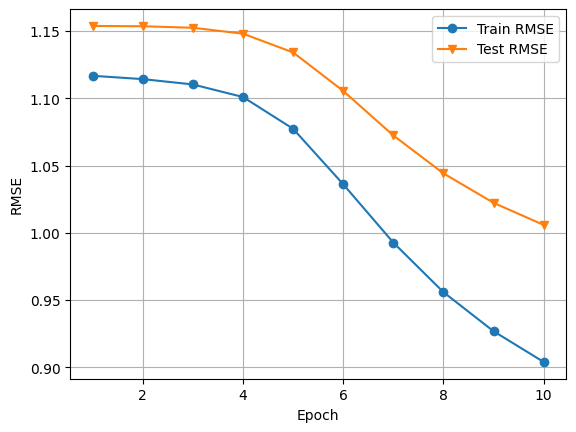

In [63]:
plt.plot(range(1, len(pmf.rmse_train)+1), pmf.rmse_train, marker='o', label='Train RMSE')
plt.plot(range(1, len(pmf.rmse_test)+1), pmf.rmse_test, marker='v', label='Test RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

### Evaluar 

In [64]:
prec, rec = pmf.topK(test, k=10)
print(f"Top-10 Precision: {prec:.4f}, Recall: {rec:.4f}")

Top-10 Precision: 0.1157, Recall: 0.0298
